# Iteración:  Modelo de aprendizaje supervisado

Para esta iteración se utlizan los datos relacionados a eventos de hurto en la ciudad de medellín y se busca predecir la cantidad de eventos utilizando redes neuronales como modelo de aprendizaje supervisado.

## Datos y preprocesamiento

La temporalidad de los datos es diria para los años 2015 a 2018

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sbn
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate, LSTM
from keras.layers import BatchNormalization, SpatialDropout1D
from keras.callbacks import Callback
from keras.models import Model
from keras.optimizers import Adam
sbn.set(rc={'figure.figsize':(10, 5)})

Using TensorFlow backend.


In [2]:
#carga de datos
datos = pd.read_excel('/home/david/Descargas/Delitos-2003-2018/Hurto.xlsx')
# filtro necesario
datos = datos[datos['Caso Hurto'] == 1]
datos.columns

Index(['Caso Hurto', 'Día', 'Hora Hurto', 'Minuto Hurto',
       'Nombre Bien Sijin Hurto', 'Grupo Bien', 'Conducta Especial',
       'Conducta', 'Modalidad', 'Sexo', 'Edad Hurto', 'Cod. Barrio', 'Barrio',
       'Cod. Comuna', 'Comuna', 'Plana X Hurto', 'Plana Y Hurto',
       'Geo X Hurto', 'Geo Y Hurto', 'Modelo Hurto', 'Linea Marca Hurto',
       'Estado Civil', 'Medio Transporte', 'Medio Transporte Agresor', 'Marca',
       'Arma Medio'],
      dtype='object')

# Modelo

Arquitectura de la Red neuronal

Ejemplo de red neuronal
<img src="Red-neuronal-artificial.png">


Perceptrón de una capa
El tipo más sencillo de red neuronal es el perceptrón de una capa, el cual consta de una sola capa de nodos de salida; las entradas están conectadas directamente a las salidas a través de una serie de ponderaciones. Es por esto que puede ser considerada el tipo más sencillo de red prealimentada. La suma de los productos de las ponderaciones y las entradas es calculada en cada nodo y, si el valor es superior a algún umbral (típicamente 0), los neurona es disparada y toma el valor de activación (típicamente 1); de forma contraria, toma el valor de desactivación (típicamente -1). Las neuronas con esta clase de función de activación son también llamadas neuronas artificiales o unidades de umbral lineal. Muchos autores usan el término perceptrón para las redes que constan de únicamente una de estas unidades.
https://es.wikipedia.org/wiki/Red_neuronal_prealimentada


### Capa entrada
30 neuronas correspondiente a la cantidad de inputs
### Capas ocultas
1 capa oculta con 30 neuronas 
### capa de salidad
La salida será 1 sola neurona
### Función de activación
Se utiliza tangente hiperbólica puesto que utilizaremos valores entre -1 y 1.

Utilizaremos como optimizador Adam y métrica de pérdida (loss) Mean Absolute Error
Como la predicción será un valor continuo y no discreto, para calcular el Acuracy utilizaremos Mean Squared Error y para saber si mejora con el entrenamiento se debería ir reduciendo con las EPOCHS.

### Referencia función de costo en redes neuronales:
http://www.diegocalvo.es/funcion-de-coste-redes-neuronales/

Adam
El optimizador Adam trata de solventar el problema con la fijación de el ratio de aprendizaje del SGD (Stochastic Gradient Descent), para ello adapta el ratio de aprendizaje en función de cómo estén distribuidos los parámetros. Si los parámetros están muy dispersos (sparse) el ratio de aprendizaje aumentará.

Adam es una actualización del Optimizador RMSProp (Root Mean Square Propagation) que se basa en un ratio de aprendizaje adaptativa.

### Flatten
se realiza para convertir los datos multidimensionales en un vector de características 1D para ser utilizado por la siguiente capa que es la capa densa

### Dropout
Técnica de regularización para reducir el sobreajuste en redes neuronales al evitar complejas adaptaciones en los datos de entrenamiento. Es una forma muy eficiente de realizar promedios de modelos con redes neuronales convolucionales (CNN). El término “abandono” se refiere al abandono de unidades (tanto ocultas como visibles) en redes neuronales.
http://sitiobigdata.com/2018/08/28/redes-neuronales-convolucionales-vista-rapida-implementacion/

## Multivariado

In [624]:
df = datos
df['ano']=df['Día'].dt.year
df = df[df['ano'] > 2015]


In [625]:
## Extracción
def group_column(data, name, group=None, func='count'):
	"""
	función para hacer agregaciones a un dataframe
	:param data: dataframe
	:param name:  string, nombre para la nueva columna
	:param group: lista o string, nombre de las columnas para agrupar
	:param func: string o numpy ej: np.sum, funcion de agregacion
	:return:
	"""
	default=['Día']
	if group:
		if type(group) == list:
			default.extend(group)
		else:
			default.append(group)
	temp = data.groupby(default).agg({'Caso Hurto': func})
	temp.columns = [name]
	df = temp.reset_index()
	df = pd.merge(data, df, how='left', on=default)
	return df, temp
df = group_column(df,'cuenta_dia')[1]
df.describe()

,cuenta_dia
count,1096.000000
mean,78.271898
std,25.188513
min,12.000000
25%,60.000000
50%,76.000000
75%,97.000000
max,182.000000


In [10]:
# extracción caracterisiticas de fecha
df['dia']=[x.weekday() for x in df.index]
df['mes']=[x.month for x in df.index]
df['dia_sem']=[x.day for x in df.index]
#df['year']=[x.year for x in df.index]

In [11]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [12]:
PASOS=30
values = df['cuenta_dia'].values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

df['scaled'] = scaled
scaledMerge=df.drop('cuenta_dia',axis=1)

reframed = series_to_supervised(scaledMerge, PASOS, 1)
reframed.head()

,var1(t-30),var2(t-30),var3(t-30),var4(t-30),var1(t-29),var2(t-29),var3(t-29),var4(t-29),var1(t-28),var2(t-28),...,var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
Día,,,,,,,,,,,,,,,,,,,,,
2017-01-31,6.0,1.0,1.0,-0.806452,0.0,1.0,2.0,-0.470968,1.0,1.0,...,29.0,-0.625807,0.0,1.0,30.0,-0.393548,1,1,31,-0.483871
2017-02-01,0.0,1.0,2.0,-0.470968,1.0,1.0,3.0,-0.561290,2.0,1.0,...,30.0,-0.393548,1.0,1.0,31.0,-0.483871,2,2,1,-0.290323
2017-02-02,1.0,1.0,3.0,-0.561290,2.0,1.0,4.0,-0.380645,3.0,1.0,...,31.0,-0.483871,2.0,2.0,1.0,-0.290323,3,2,2,-0.200000
2017-02-03,2.0,1.0,4.0,-0.380645,3.0,1.0,5.0,-0.587097,4.0,1.0,...,1.0,-0.290323,3.0,2.0,2.0,-0.200000,4,2,3,-0.548387
2017-02-04,3.0,1.0,5.0,-0.587097,4.0,1.0,6.0,-0.329032,5.0,1.0,...,2.0,-0.200000,4.0,2.0,3.0,-0.548387,5,2,4,-0.587097


In [13]:
newReframed=reframed.drop(['var1(t)','var2(t)', 'var3(t)'],axis=1)
print(newReframed.shape)
newReframed.head()

(700, 121)


,var1(t-30),var2(t-30),var3(t-30),var4(t-30),var1(t-29),var2(t-29),var3(t-29),var4(t-29),var1(t-28),var2(t-28),...,var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var4(t)
Día,,,,,,,,,,,,,,,,,,,,,
2017-01-31,6.0,1.0,1.0,-0.806452,0.0,1.0,2.0,-0.470968,1.0,1.0,...,-0.419355,6.0,1.0,29.0,-0.625807,0.0,1.0,30.0,-0.393548,-0.483871
2017-02-01,0.0,1.0,2.0,-0.470968,1.0,1.0,3.0,-0.561290,2.0,1.0,...,-0.625807,0.0,1.0,30.0,-0.393548,1.0,1.0,31.0,-0.483871,-0.290323
2017-02-02,1.0,1.0,3.0,-0.561290,2.0,1.0,4.0,-0.380645,3.0,1.0,...,-0.393548,1.0,1.0,31.0,-0.483871,2.0,2.0,1.0,-0.290323,-0.200000
2017-02-03,2.0,1.0,4.0,-0.380645,3.0,1.0,5.0,-0.587097,4.0,1.0,...,-0.483871,2.0,2.0,1.0,-0.290323,3.0,2.0,2.0,-0.200000,-0.548387
2017-02-04,3.0,1.0,5.0,-0.587097,4.0,1.0,6.0,-0.329032,5.0,1.0,...,-0.290323,3.0,2.0,2.0,-0.200000,4.0,2.0,3.0,-0.548387,-0.587097


In [14]:
# split into train and test sets
values = newReframed.values
n_train_days = int(len(newReframed)*.8)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(560, 1, 120) (560,) (140, 1, 120) (140,)


In [626]:
neurona_entrada = 30
neurona_oculta = 3
neurona_oculta2 = 4

def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(neurona_entrada, input_shape=(1,x_train.shape[2]),activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(neurona_oculta, activation='tanh'))
    #model.add(Dropout(0.5))
    #model.add(Dense(neurona_oculta2, activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [627]:
EPOCHS=184
model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_281 (Dense)            (None, 1, 30)             3630      
_________________________________________________________________
dropout_76 (Dropout)         (None, 1, 30)             0         
_________________________________________________________________
dense_282 (Dense)            (None, 1, 3)              93        
_________________________________________________________________
flatten_75 (Flatten)         (None, 3)                 0         
_________________________________________________________________
dense_283 (Dense)            (None, 1)                 4         
Total params: 3,727
Trainable params: 3,727
Non-trainable params: 0
_________________________________________________________________
Train on 560 samples, validate on 140 samples
Epoch 1/184
560/560 [==============================] - 0s 652us/step - 

In [628]:
#loss: 0.1286 - mse: 0.0298 - val_loss: 0.1728 - val_mse: 0.0531   drop 0.15 pasos 30 2015
results=model.predict(x_val)

compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(10)

,real,prediccion,diferencia
0,98.000000,110.184052,-12.184052
1,134.000004,111.186376,22.813628
2,102.999996,115.610556,-12.610561
3,126.000002,113.344380,12.655622
4,106.000002,111.124624,-5.124622
5,57.000002,86.144959,-29.144957
6,57.000002,92.039841,-35.039839
7,101.999997,102.715320,-0.715324
8,102.999996,102.773327,0.226669
9,119.999998,101.576489,18.423509


In [629]:
compara2.describe()

,real,prediccion,diferencia
count,140.000000,140.000000,140.000000
mean,99.378571,98.137499,1.241072
std,22.834238,12.659616,17.736125
min,30.000000,61.396995,-64.765464
25%,86.750002,92.429785,-8.765396
50%,103.500000,102.718914,1.183342
75%,111.999997,105.711165,12.684633
max,157.000001,115.610556,45.892120


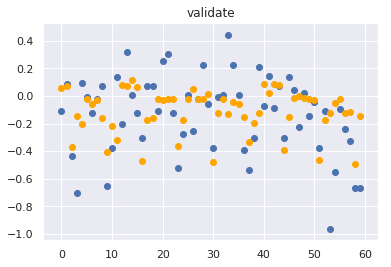

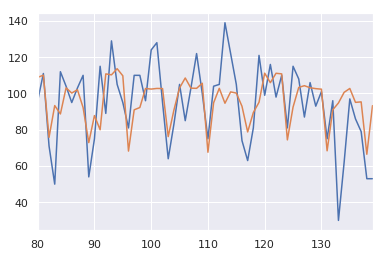

In [630]:
results=model.predict(x_val)
window = 60
plt.scatter(range(len(y_val[-window:])),y_val[-window:],c='b')
plt.scatter(range(len(results[-window:])),results[-window:],c='orange')
plt.title('validate')
plt.show()
compara2['real'][len(compara2)-window:].plot()
compara2['prediccion'][len(compara2)-window:].plot()

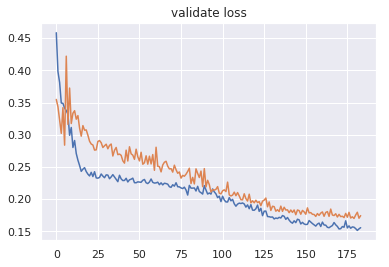

In [631]:
#plt.ylim(5, 30)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

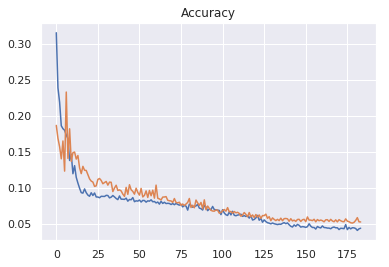

In [632]:
#plt.ylim(150, 1000)
plt.title('Accuracy')
plt.plot(history.history['mse'])

plt.plot(history.history['val_mse'])
plt.show()

In [633]:
min(history.history['val_mse'])

0.0506744310259819

# Embeddings

In [19]:
df = datos
df['ano']=df['Día'].dt.year
df = df[df['ano'] > 2015]
#df = df[df['ano'] < 2018]

## Extracción
def group_column(data, name, group=None, func='count'):
	"""
	función para hacer agregaciones a un dataframe
	:param data: dataframe
	:param name:  string, nombre para la nueva columna
	:param group: lista o string, nombre de las columnas para agrupar
	:param func: string o numpy ej: np.sum, funcion de agregacion
	:return:
	"""
	default=['Día']
	if group:
		if type(group) == list:
			default.extend(group)
		else:
			default.append(group)
	temp = data.groupby(default).agg({'Caso Hurto': func})
	temp.columns = [name]
	df = temp.reset_index()
	df = pd.merge(data, df, how='left', on=default)
	return df, temp
df = group_column(df,'cuenta_dia')[1]
df.describe()

,cuenta_dia
count,1096.000000
mean,78.271898
std,25.188513
min,12.000000
25%,60.000000
50%,76.000000
75%,97.000000
max,182.000000


In [20]:
df['dia']=[x.weekday() for x in df.index]
df['mes']=[x.month for x in df.index]
#df['dia_sem']=[x.day for x in df.index]
df['year']=[x.year for x in df.index]

df.head()

,cuenta_dia,dia,mes,year
Día,,,,
2016-01-01,33,4,1,2016
2016-01-02,37,5,1,2016
2016-01-03,34,6,1,2016
2016-01-04,50,0,1,2016
2016-01-05,39,1,1,2016


In [21]:
PASOS=14
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [22]:
# load dataset
values = df['cuenta_dia'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))

values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.reset_index(inplace=True, drop=True)

contador=0
reframed['dia']=df['dia']
reframed['mes']=df['mes']
reframed['year']=df['year']
#reframed['dia_sem']=df['dia_sem']

for i in range(reframed.index[0],reframed.index[-1]):
    reframed['dia'].loc[contador]=df['dia'][i+8]
    reframed['mes'].loc[contador]=df['mes'][i+8]
    reframed['year'].loc[contador]=df['year'][i+8]
    #reframed['dia_sem'].loc[contador]=df['dia_sem'][i+8]
    contador=contador+1
reframed.head()

/home/david/jupyternot/local/lib/python3.5/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),dia,mes,year
0,-0.752941,-0.705882,-0.741176,-0.552941,-0.682353,-0.623529,-0.411765,-0.400000,-0.670588,-0.776471,-0.717647,-0.541176,-0.517647,-0.470588,-0.400000,5.0,1.0,2016.0
1,-0.705882,-0.741176,-0.552941,-0.682353,-0.623529,-0.411765,-0.400000,-0.670588,-0.776471,-0.717647,-0.541176,-0.517647,-0.470588,-0.400000,-0.505882,6.0,1.0,2016.0
2,-0.741176,-0.552941,-0.682353,-0.623529,-0.411765,-0.400000,-0.670588,-0.776471,-0.717647,-0.541176,-0.517647,-0.470588,-0.400000,-0.505882,-0.800000,0.0,1.0,2016.0
3,-0.552941,-0.682353,-0.623529,-0.411765,-0.400000,-0.670588,-0.776471,-0.717647,-0.541176,-0.517647,-0.470588,-0.400000,-0.505882,-0.800000,-0.647059,1.0,1.0,2016.0
4,-0.682353,-0.623529,-0.411765,-0.400000,-0.670588,-0.776471,-0.717647,-0.541176,-0.517647,-0.470588,-0.400000,-0.505882,-0.800000,-0.647059,-0.670588,2.0,1.0,2016.0


In [23]:
val= reframed.columns[-3:].append(reframed.columns[:-3])
reordenado=reframed[val].copy()
reordenado.dropna(inplace=True)
reordenado

,dia,mes,year,var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
0,5.0,1.0,2016.0,-0.752941,-0.705882,-0.741176,-0.552941,-0.682353,-0.623529,-0.411765,-0.400000,-0.670588,-0.776471,-0.717647,-0.541176,-0.517647,-0.470588,-0.400000
1,6.0,1.0,2016.0,-0.705882,-0.741176,-0.552941,-0.682353,-0.623529,-0.411765,-0.400000,-0.670588,-0.776471,-0.717647,-0.541176,-0.517647,-0.470588,-0.400000,-0.505882
2,0.0,1.0,2016.0,-0.741176,-0.552941,-0.682353,-0.623529,-0.411765,-0.400000,-0.670588,-0.776471,-0.717647,-0.541176,-0.517647,-0.470588,-0.400000,-0.505882,-0.800000
3,1.0,1.0,2016.0,-0.552941,-0.682353,-0.623529,-0.411765,-0.400000,-0.670588,-0.776471,-0.717647,-0.541176,-0.517647,-0.470588,-0.400000,-0.505882,-0.800000,-0.647059
4,2.0,1.0,2016.0,-0.682353,-0.623529,-0.411765,-0.400000,-0.670588,-0.776471,-0.717647,-0.541176,-0.517647,-0.470588,-0.400000,-0.505882,-0.800000,-0.647059,-0.670588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1076,3.0,12.0,2018.0,0.023529,0.223529,0.011765,0.152941,-0.188235,0.211765,0.129412,-0.117647,0.105882,-0.047059,0.047059,-0.258824,-0.011765,-0.788235,-0.411765
1077,4.0,12.0,2018.0,0.223529,0.011765,0.152941,-0.188235,0.211765,0.129412,-0.117647,0.105882,-0.047059,0.047059,-0.258824,-0.011765,-0.788235,-0.411765,0.000000
1078,5.0,12.0,2018.0,0.011765,0.152941,-0.188235,0.211765,0.129412,-0.117647,0.105882,-0.047059,0.047059,-0.258824,-0.011765,-0.788235,-0.411765,0.000000,-0.129412
1079,6.0,12.0,2018.0,0.152941,-0.188235,0.211765,0.129412,-0.117647,0.105882,-0.047059,0.047059,-0.258824,-0.011765,-0.788235,-0.411765,0.000000,-0.129412,-0.211765


In [24]:
training_data = reordenado.drop('var1(t)',axis=1)#.values
target_data=reordenado['var1(t)']
#training_data.head()
valid_data = training_data[len(df)-151:]
valid_target=target_data[len(df)-151:]

training_data = training_data[0:len(df)]
target_data=target_data[0:len(df)]
print(training_data.shape,target_data.shape,valid_data.shape,valid_target.shape)
#training_data.head()

(1081, 17) (1081,) (136, 17) (136,)


In [25]:
def crear_modeloEmbeddings():
    emb_dias = 30 #tamanio profundidad de embeddings
    #emb_dia_sem = 30
    emb_meses = 180
    emb_year = 365

    in_dias = Input(shape=[1], name = 'dias')
    emb_dias = Embedding(7+1, emb_dias)(in_dias)
    #emb_dias = SpatialDropout1D(0.2)(emb_dias)
    in_meses = Input(shape=[1], name = 'meses')
    emb_meses = Embedding(12+1, emb_meses)(in_meses)
    emb_meses = SpatialDropout1D(0.95)(emb_meses)
    in_year = Input(shape=[1], name = 'year')
    emb_year = Embedding(2018+1, emb_year)(in_year)
    emb_year = SpatialDropout1D(0.95)(emb_year)
    in_cli = Input(shape=[PASOS], name = 'cli')
    fe = concatenate([(emb_dias), (emb_meses), (emb_year)])
    x = Flatten()(fe)
    x = Dense(PASOS,activation='tanh')(x)
    outp = Dense(1,activation='tanh')(x)
    model = Model(inputs=[in_dias,in_meses, in_year, in_cli], outputs=outp)

    model.compile(loss='mean_absolute_error', 
                  optimizer='adam',
                  metrics=['mse'])

    model.summary()
    return model

In [26]:
EPOCHS=64

model = crear_modeloEmbeddings()

continuas=training_data[training_data.columns[3:]]
valid_continuas=valid_data[training_data.columns[3:]]

history=model.fit([training_data['dia'],training_data['mes'], training_data['year'], continuas], target_data, epochs=EPOCHS
                 ,validation_data=([valid_data['dia'],valid_data['mes'], valid_data['year'], valid_continuas],valid_target))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
meses (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
year (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
dias (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 180)       2340        meses[0][0]                      
____________________________________________________________________________________________

/home/david/jupyternot/local/lib/python3.5/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1081 samples, validate on 136 samples
Epoch 1/64
1081/1081 [==============================] - 1s 674us/step - loss: 0.2490 - mse: 0.0965 - val_loss: 0.1869 - val_mse: 0.0559
Epoch 2/64
1081/1081 [==============================] - 0s 305us/step - loss: 0.1979 - mse: 0.0646 - val_loss: 0.1474 - val_mse: 0.0375
Epoch 3/64
1081/1081 [==============================] - 0s 307us/step - loss: 0.1710 - mse: 0.0503 - val_loss: 0.1459 - val_mse: 0.0375
Epoch 4/64
1081/1081 [==============================] - 0s 330us/step - loss: 0.1613 - mse: 0.0448 - val_loss: 0.1359 - val_mse: 0.0351
Epoch 5/64
1081/1081 [==============================] - 0s 434us/step - loss: 0.1553 - mse: 0.0422 - val_loss: 0.1363 - val_mse: 0.0361
Epoch 6/64
1081/1081 [==============================] - 0s 415us/step - loss: 0.1538 - mse: 0.0408 - val_loss: 0.1360 - val_mse: 0.0351
Epoch 7/64
1081/1081 [==============================] - 0s 345us/step - loss: 0.1529 - mse: 0.0414 - val_loss: 0.1365 - val_mse: 0.0373
E

In [27]:
#loss: 0.0452 - MSE: 0.0452 - val_loss: 0.0424 - val_MSE: 0.0424  2016

results=model.predict([valid_data['dia'],valid_data['mes'], valid_data['year'], valid_continuas])

compara = pd.DataFrame(np.array([valid_target, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(7)

,real,prediccion,diferencia
0,126.0,113.000526,12.999474
1,106.0,105.863571,0.136429
2,57.0,62.904125,-5.904125
3,57.0,102.811234,-45.811234
4,102.0,101.854851,0.145149
5,103.0,110.158791,-7.158791
6,120.0,111.498810,8.501190


In [28]:
compara2.describe()

,real,prediccion,diferencia
count,136.000000,136.000000,136.000000
mean,99.448532,102.374321,-2.925791
std,22.625721,16.697773,16.388536
min,29.999998,60.060314,-67.817467
25%,86.750000,102.811234,-9.252245
50%,104.000000,107.177155,-1.741375
75%,112.000000,112.610975,7.520697
max,157.000000,117.728775,43.035851


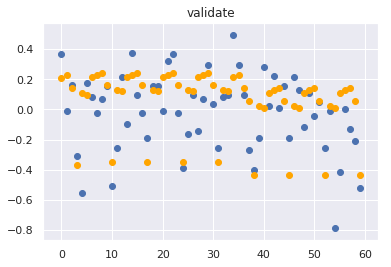

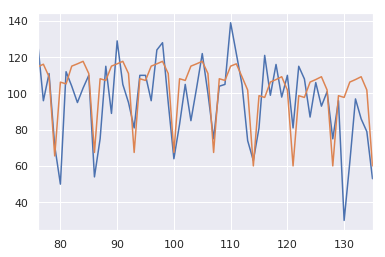

In [29]:
window = 60
plt.scatter(range(len(valid_target[-window:])),valid_target[-window:],c='b')
plt.scatter(range(len(results[-window:])),results[-window:],c='orange')
plt.title('validate')
plt.show()
compara2['real'][len(compara2)-window:].plot()
compara2['prediccion'][len(compara2)-window:].plot()

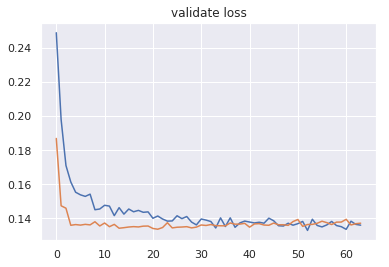

In [30]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

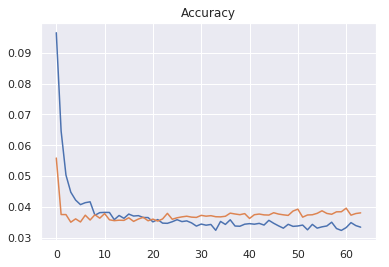

In [31]:
plt.title('Accuracy')
plt.plot(history.history['mse'])

plt.plot(history.history['val_mse'])
plt.show()